# Physics Informed Neural Networks

This notebook implements PINNs from Raissi et al. 2017. Specifically, the notebook adapts the code implementation of Data-Driven Solutions of Nonlinear Partial Differential Equations from https://github.com/maziarraissi/PINNs, and the code by Michael Ito, to solve the force-field equation for solar modulation of cosmic rays. Michael Ito's code adaption use the TF2 API where the main mechanisms of the PINN arise in the train_step function efficiently computing higher order derivatives of custom loss functions through the use of the GradientTape data structure. 

In this application, our PINN is $h(r, p) = \frac{\partial f}{\partial r} + \frac{RV}{3k} \frac{\partial f}{\partial p}$ where $k=\beta(p)k_1(r)k_2(r)$ and $\beta = \frac{p}{\sqrt{p^2 + M^2}}$. We will approximate $f(r, p)$ using a neural network.

We have no initial data, but our boundary data will be given by $f(r_{HP}, p) = \frac{J(r_{HP}, T)}{p^2} = \frac{(T+M)^\gamma}{p^2}$, where $r_{HP} = 120$ AU (i.e. the radius of Heliopause), $M=0.938$ GeV, $\gamma$ is between $-2$ and $-3$, and $T = \sqrt{p^2 + M^2} - M$. Or, vice versa, $p = \sqrt{T^2 + 2TM}$.


In [8]:
# Imports
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import pickle as pkl
import pandas as pd
import matplotlib.pyplot as plt

tfd = tfp.distributions
tfm = tf.math
tf.config.list_physical_devices(device_type=None)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

## Load the Data

In [9]:
# Constants  
m = 0.938 # GeV/c^2
gamma = -3 # Between -2 and -3
size = 512 # size of r, T, p, and f_boundary
au = 150e6 # 150e6 m/AU
r_limits = [119, 120]
T_limits = [0.001, 1000]

# Create boundary data
T = np.logspace(np.log10(T_limits[0]), np.log10(T_limits[1]), size).flatten()[:, None]
p = (np.sqrt((T+m)**2-m**2)).flatten()[:,None] # GeV/c
r = np.logspace(np.log10(r_limits[0]*au), np.log10(r_limits[1]*au), size).flatten()[:, None] # km
f_boundary = ((T + m)**gamma)/(p**2) # particles/(m^3 (GeV/c)^3)

# Get upper and lower bounds
lb = np.array([p[0], r[0]], dtype='float32')
ub = np.array([p[-1], r[-1]], dtype='float32')

# Create test data
p_predict = np.log(p)
r_predict = np.log(r)

p_predict = (p_predict - lb[0])/np.abs(ub[0] - lb[0])
r_predict = (r_predict - lb[1])/np.abs(ub[1] - lb[1])
    
P, R = np.meshgrid(p_predict, r_predict)
P_predict = np.hstack((P.flatten()[:,None], R.flatten()[:,None]))

r: (512, 1), p: (512, 1), T: (512, 1), f_boundary: (512, 1), P_predict: (262144, 2)
lb: [[4.332436e-02]
 [1.785000e+10]], ub:[[1.00093756e+03]
 [1.80000010e+10]]


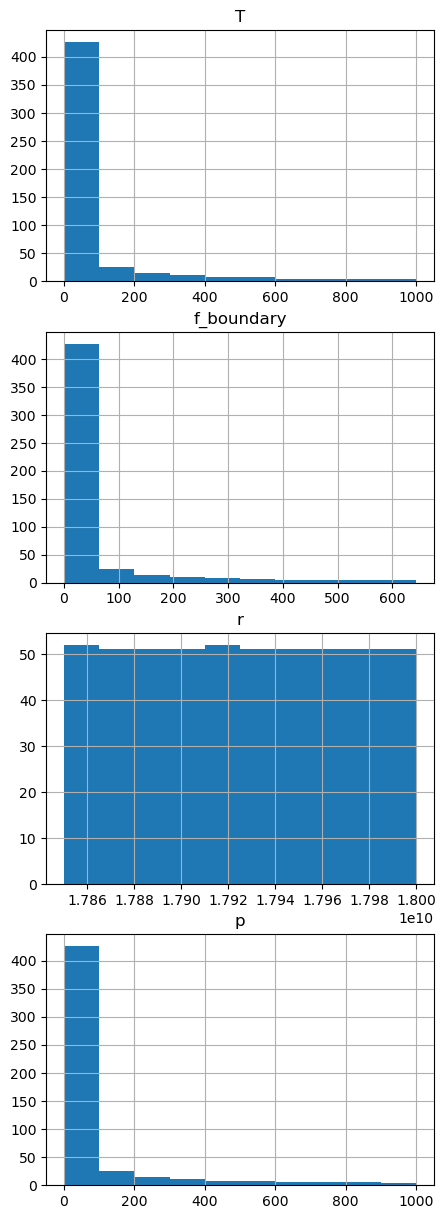

In [10]:
# Check inputs
print(f'r: {r.shape}, p: {p.shape}, T: {T.shape}, f_boundary: {f_boundary.shape}, P_predict: {P_predict.shape}')
print(f'lb: {lb}, ub:{ub}')

# Visualize
fig, axs = plt.subplots(4, figsize=(5, 15))
for ax, data, name in zip(axs, [T, f_boundary, r, p], ['T', 'f_boundary', 'r', 'p']):
    ax.set_title(name)
    pd.Series(data[:, 0]).hist(ax=ax)

## PINN Class

The PINN class subclasses the Keras Model so that we can implement our custom fit and train_step functions.

In [4]:
'''
Description: Defines the class for a PINN model implementing train_step, fit, and predict functions. Note, it is necessary 
to design each PINN seperately for each system of PDEs since the train_step is customized for a specific system. 
This PINN in particular solves the force-field equation for solar modulation of cosmic rays. Once trained, the PINN can predict the solution space given 
domain bounds and the input space. 
'''
class PINN(tf.keras.Model):
    def __init__(self, inputs, outputs, lower_bound, upper_bound, p, f_boundary, size, n_samples=20000):
        super(PINN, self).__init__(inputs=inputs, outputs=outputs)
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.p = p
        self.f_boundary = f_boundary
        self.n_samples = n_samples
        self.size = size
        
    '''
    Description: A system of PDEs are determined by 2 types of equations: the main partial differential equations 
    and the boundary value equations. These two equations will serve as loss functions which 
    we train the PINN to satisfy. If a PINN can satisfy BOTH equations, the system is solved. Since there are 2 types of 
    equations (PDE, Boundary Value), we will need 2 types of inputs. Each input is composed of a spatial 
    variable 'r' and a momentum variable 'p'. The different types of (p, r) pairs are described below.
    
    Inputs: 
        p, r: (batchsize, 1) shaped arrays : These inputs are used to derive the main partial differential equation loss.
        Train step first feeds (p, r) through the PINN for the forward propagation. This expression is PINN(p, r) = f. 
        Next, the partials f_p and f_r are obtained. We utilize TF2s GradientTape data structure to obtain all partials. 
        Once we obtain these partials, we can compute the main PDE loss and optimize weights w.r.t. to the loss. 
        
        p_boundary, r_boundary : (boundary_batchsize, 1) shaped arrays : These inputs are used to derive the boundary value
        equations. The boundary value loss relies on target data (**not an equation**), so we can just measure the MAE of 
        PINN(p_boundary, r_boundary) = f_pred_boundary and f_boundary.
        
        f_boundary: (boundary_batchsize, 1) shaped arrays : This is the target data for the boundary value inputs
        
        alpha: weight on boundary_loss, 1-alpha weight on pinn_loss
        
        beta: boundary_loss scale factor
        
    Outputs: sum_loss, pinn_loss, boundary_loss
    '''
    def train_step(self, p, r, p_boundary, r_boundary, f_boundary, alpha, beta):
        with tf.GradientTape(persistent=True) as t2: 
            with tf.GradientTape(persistent=True) as t1: 
                t1.watch(p)
                t1.watch(r)
                
                lb = tfm.log(self.lower_bound)
                ub = tfm.log(self.upper_bound)
                
                # PINN loss
                p_scaled = (tfm.log(p) - lb[0])/tfm.abs(ub[0] - lb[0])
                r_scaled = (tfm.log(r) - lb[1])/tfm.abs(ub[1] - lb[1])
                
                P = tf.concat((p_scaled, r_scaled), axis=1)
                f = self.tf_call(P)

                # Boundary loss
                p_boundary_scaled = (tfm.log(p_boundary) - lb[0])/tfm.abs(ub[0] - lb[0])
                r_boundary_scaled = (tfm.log(r_boundary) - lb[1])/tfm.abs(ub[1] - lb[1])
                
                P_boundary = tf.concat((p_boundary_scaled, r_boundary_scaled), axis=1)
                f_pred_boundary = self.tf_call(P_boundary)

                boundary_loss = tfm.reduce_mean(tfm.abs(f_pred_boundary - f_boundary))

            # Calculate first-order PINN gradients
            f_p = t1.gradient(f, p)
            f_r = t1.gradient(f, r)
            
            pinn_loss = self.pinn_loss(p, r, f_p, f_r)
            total_loss = (1-alpha)*pinn_loss + alpha*beta*boundary_loss

        # Backpropagation
        gradients = t2.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        return pinn_loss.numpy(), boundary_loss.numpy()
    
    '''
    Description: The fit function used to iterate through epoch * steps_per_epoch steps of train_step. 
    
    Inputs: 
        P_predict: (N, 2) array: Input data for entire spatial and temporal domain. Used for vizualization for
        predictions at the end of each epoch. Michael created a very pretty video file with it. 
        
        alpha: weight on boundary_loss, 1-alpha weight on pinn_loss
        
        beta: boundary_loss scale factor
        
        batchsize: batchsize for (p, r) in train step
        
        boundary_batchsize: batchsize for (x_lower, t_boundary) and (x_upper, t_boundary) in train step
        
        epochs: epochs
        
        lr: learning rate
        
        size: size of the prediction data (i.e. len(p) and len(r))
        
        save: Whether or not to save the model to a checkpoint every 10 epochs
        
        load_epoch: If -1, a saved model will not be loaded. Otherwise, the model will be 
        loaded from the provided epoch
        
        lr_decay: If -1, learning rate will not be decayed. Otherwise, lr = lr_decay*lr if loss hasn't 
        decreased
        
        alpha_decay: If -1, alpha will not be changed. Otherwise, alpha = alpha_decay*alpha if loss 
        hasn't decreased
        
        alpha_limit = Minimum alpha value to decay to
        
        patience: Number of epochs to check whether loss has decreased before updating lr or alpha
        
        filename: Name for the checkpoint file
    
    Outputs: Losses for each equation (Total, PDE, Boundary Value), and predictions for each epoch.
    '''
    def fit(self, P_predict, alpha=0.5, beta=0.01, batchsize=64, boundary_batchsize=16, epochs=20, lr=3e-3, size=256, 
            save=False, load_epoch=-1, lr_decay=-1, alpha_decay=-1, alpha_limit = 0.5, patience=3, filename=''):
        
        # If load == True, load the weights
        if load_epoch != -1:
            name = './ckpts/pinn_' + filename + '_epoch_' + str(load_epoch)
            self.load_weights(name)
        
        # Initialize
        steps_per_epoch = np.ceil(self.n_samples / batchsize).astype(int)
        total_pinn_loss = np.zeros((epochs,))
        total_boundary_loss = np.zeros((epochs,))
        predictions = np.zeros((size**2, 1, epochs))
        
        # For each epoch, sample new values in the PINN and boundary areas and pass them to train_step
        for epoch in range(epochs):
            # Compile
            opt = tf.keras.optimizers.Adam(learning_rate=lr)
            self.compile(optimizer=opt)

            sum_loss = np.zeros((steps_per_epoch,))
            pinn_loss = np.zeros((steps_per_epoch,))
            boundary_loss = np.zeros((steps_per_epoch,))
            
            # For each step, sample data and pass to train_step
            for step in range(steps_per_epoch):
                # Sample p and r according to a beta distribution between upper and lower bounds
                dist = tfd.Beta(1, 5)
                p = (dist.sample((batchsize, 1))*tfm.abs(self.upper_bound[0] - self.lower_bound[0])) + self.lower_bound[0]
                r = (dist.sample((batchsize, 1))*tfm.abs(self.upper_bound[1] - self.lower_bound[1])) + self.lower_bound[1]
                
                # Randomly sample boundary_batchsize from p_boundary and f_boundary
                p_idx = np.expand_dims(np.random.choice(self.f_boundary.shape[0], boundary_batchsize, replace=False), axis=1)
                p_boundary = tf.Variable(self.p[p_idx], dtype=tf.float32)
                f_boundary = self.f_boundary[p_idx]
                
                # Create r_boundary array = r_HP
                upper_bound = np.zeros((boundary_batchsize, 1))
                upper_bound[:] = self.upper_bound[1]
                r_boundary = tf.Variable(upper_bound, dtype=tf.float32)
                
                # Train and get loss
                losses = self.train_step(p, r, p_boundary, r_boundary, f_boundary, alpha, beta)
                pinn_loss[step] = losses[0]
                boundary_loss[step] = losses[1]
            
            # Sum losses
            total_pinn_loss[epoch] = np.sum(pinn_loss)
            total_boundary_loss[epoch] = np.sum(boundary_loss)
            print(f'Epoch {epoch}. Current alpha: {alpha:.4f}, lr: {lr:.6f}. Training losses: pinn: {total_pinn_loss[epoch]:.10f}, ' +
                  f'boundary: {total_boundary_loss[epoch]:.6f}, weighted total: {((alpha*beta*total_boundary_loss[epoch])+((1-alpha)*total_pinn_loss[epoch])):.4f}')
            
            predictions[:, :, epoch] = self.predict(P_predict, batchsize)
            
            # Decay lr if loss hasn't decreased since current epoch - patience
            if (epoch > patience):
                hasntDecreased = False
                if (total_pinn_loss[epoch] + total_boundary_loss[epoch]) > (total_pinn_loss[epoch-patience] + total_boundary_loss[epoch-patience]):
                    hasntDecreased = True
                        
                if (lr_decay != -1) & hasntDecreased:
                    lr = lr_decay*lr

            # Decrease alpha each epoch
            if if (alpha_decay != -1) & (alpha >= alpha_limit):
                alpha = alpha_decay*alpha

            # If the epoch is a multiple of 10, save to a checkpoint
            if (epoch%10 == 0) & (save == True):
                name = './ckpts/pinn_' + filename + '_epoch_' + str(epoch)
                self.save_weights(name, overwrite=True, save_format=None, options=None)
        
        return total_pinn_loss, total_boundary_loss, predictions
    
    # Predict for some P's the value of the neural network f(r, p)
    def predict(self, P, batchsize):
        P_size = P.shape[0]
        steps_per_epoch = np.ceil(P_size / batchsize).astype(int)
        predictions = np.zeros((P_size, 1))
        
        # For each step predict on data between start and end indices
        for step in range(steps_per_epoch):
            start_idx = step * 64
            
            # Calculate end_idx
            if step == steps_per_epoch - 1:
                end_idx = P_size - 1
            else:
                end_idx = start_idx + 64
                
            # Predict
            predictions[start_idx:end_idx, :] = self.tf_call(P[start_idx:end_idx, :]).numpy()
        
        return predictions
    
    def evaluate(self, ): 
        pass
    
    # pinn_loss calculates the PINN loss by calculating the MAE of the pinn function
    @tf.function
    def pinn_loss(self, p, r, f_p, f_r):
        V = 400 # 400 km/s
        m = 0.938 # GeV/c^2
        k_0 = 1e11 # km^2/s
        k_1 = k_0 * tfm.divide(r, 150e6) # km^2/s
        k_2 = p # unitless, k_2 = p/p0 and p0 = 1 GeV/c
        R = p # GV
        beta = tfm.divide(p, tfm.sqrt(tfm.square(p) + tfm.square(m))) 
        k = beta*k_1*k_2
        
        # Calculate physics loss
        l_f = tfm.reduce_mean(tfm.abs(f_r + (tfm.divide(R*V, 3*k) * f_p)))
        
        return l_f
    
    # tf_call passes inputs through the neural network
    @tf.function
    def tf_call(self, inputs): 
        return self.call(inputs, training=True)

In [5]:
# Neural network. Note: 2 inputs- (p, r), 1 output- f(r, p)
inputs = tf.keras.Input((2))
x_ = tf.keras.layers.Dense(100, activation='selu')(inputs)
x_ = tf.keras.layers.Dense(100, activation='selu')(x_)
x_ = tf.keras.layers.Dense(100, activation='selu')(x_)
x_ = tf.keras.layers.Dense(100, activation='selu')(x_)
outputs = tf.keras.layers.Dense(1, activation='linear')(x_) 

# Hyperparameters
alpha = 0.9
alpha_decay = 0.998
beta = 1e-4
lr = 3e-4
lr_decay = 0.95
patience = 10
batchsize = 1032
boundary_batchsize = 256
epochs = 500
save = False
load_epoch = -1
filename = ''

# Initialize and fit the PINN
pinn = PINN(inputs=inputs, outputs=outputs, lower_bound=lb, upper_bound=ub, p=p[:, 0], f_boundary=f_boundary[:, 0], size=size)
pinn_loss, boundary_loss, predictions = pinn.fit(P_predict=P_predict, alpha=alpha, beta=beta, batchsize=batchsize, boundary_batchsize=boundary_batchsize,
                                                         epochs=epochs, lr=lr, size=size, save=save, load_epoch=load_epoch, lr_decay=lr_decay,
                                                         alpha_decay=alpha_decay, patience=patience, filename=filename)

2022-10-14 12:04:08.912629: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 0. Current alpha: 0.9000, lr: 0.000300. Training losses: pinn: 0.000000, boundary: 930.456779, weighted total: 0.0837
Epoch 1. Current alpha: 0.8982, lr: 0.000300. Training losses: pinn: 0.000000, boundary: 887.663490, weighted total: 0.0797
Epoch 2. Current alpha: 0.8964, lr: 0.000300. Training losses: pinn: 0.000000, boundary: 895.732655, weighted total: 0.0803
Epoch 3. Current alpha: 0.8946, lr: 0.000300. Training losses: pinn: 0.000001, boundary: 908.502922, weighted total: 0.0813
Epoch 4. Current alpha: 0.8928, lr: 0.000300. Training losses: pinn: 0.000001, boundary: 870.246075, weighted total: 0.0777
Epoch 5. Current alpha: 0.8910, lr: 0.000300. Training losses: pinn: 0.000001, boundary: 908.540840, weighted total: 0.0810
Epoch 6. Current alpha: 0.8893, lr: 0.000300. Training losses: pinn: 0.000001, boundary: 863.616199, weighted total: 0.0768
Epoch 7. Current alpha: 0.8875, lr: 0.000300. Training losses: pinn: 0.000001, boundary: 912.773079, weighted total: 0.0810
Epoch 8.

## Save the outputs to a pickle

In [7]:
# Save PINN outputs
with open('./figures/pickles/pinn_loss_' + filename + '.pkl', 'wb') as file:
    pkl.dump(pinn_loss, file)
    
with open('./figures/pickles/boundary_loss_' + filename + '.pkl', 'wb') as file:
    pkl.dump(boundary_loss, file)
     
with open('./figures/pickles/predictions_' + filename + '.pkl', 'wb') as file:
    pkl.dump(predictions, file)
    
with open('./figures/pickles/f_boundary.pkl', 'wb') as file:
    pkl.dump(f_boundary, file)
    
with open('./figures/pickles/p.pkl', 'wb') as file:
    pkl.dump(p, file)
    
with open('./figures/pickles/T.pkl', 'wb') as file:
    pkl.dump(T, file)
    
with open('./figures/pickles/r.pkl', 'wb') as file:
    pkl.dump(r, file)